In [1]:
import sys
sys.version

'3.5.4 |Anaconda, Inc.| (default, Nov  8 2017, 14:34:30) [MSC v.1900 64 bit (AMD64)]'

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
from datetime import datetime
%matplotlib inline
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

In [3]:
data = pd.read_csv('USDRUB_150228_180530.csv', sep=';', names=['date', 'time', 'open', 'high', 'low', 'close', 'V'], header=0)
data.index = data.apply(lambda row: datetime.strptime(str(row['date']) + ' ' + str(row['time']), '%d/%m/%y %H:%M:%S'), axis=1)
#data.drop(data[data.V < 10000].index, inplace=True)
data.drop(['date', 'time'], axis=1, inplace=True)

In [4]:
data.shape

(21305, 5)

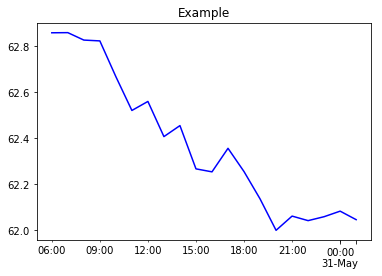

In [5]:
ts = data['close']
ts[-20:].plot(c='b', title='Example')
plt.show()

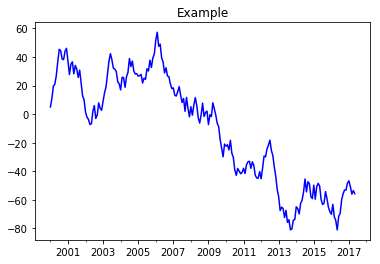

2000-01-31     5.102277
2000-02-29    10.910794
2000-03-31    19.592823
2000-04-30    20.974212
2000-05-31    26.818273
2000-06-30    36.551878
2000-07-31    45.413375
2000-08-31    44.534744
2000-09-30    38.585294
2000-10-31    38.184853
2000-11-30    44.052184
2000-12-31    46.089435
2001-01-31    36.773836
2001-02-28    27.743297
2001-03-31    35.087183
2001-04-30    36.608726
2001-05-31    28.260413
2001-06-30    34.173222
2001-07-31    31.544759
2001-08-31    25.734625
2001-09-30    30.800656
2001-10-31    21.461837
2001-11-30    12.755927
2001-12-31     9.978173
2002-01-31     1.384433
2002-02-28    -2.068786
2002-03-31    -3.682967
2002-04-30    -7.235065
2002-05-31    -6.748913
2002-06-30     1.897948
                ...    
2014-12-31   -59.098747
2015-01-31   -49.684332
2015-02-28   -59.509507
2015-03-31   -50.592186
2015-04-30   -48.432621
2015-05-31   -50.423187
2015-06-30   -59.746632
2015-07-31   -63.250785
2015-08-31   -62.400282
2015-09-30   -54.197004
2015-10-31   -59

In [6]:
random.seed(111)
rng = pd.date_range(start='2000', periods=209, freq='M')
ts = pd.Series(np.random.uniform(-10, 10, size=len(rng)), rng).cumsum()
ts.plot(c='b', title='Example')
plt.show()
ts

In [7]:
TS = np.array(ts)
num_periods = 20
f_horizon = 1
x_data = TS[:(len(TS) - (len(TS) % num_periods)) - num_periods]
x_batches = x_data.reshape(-1, 20, 1)

y_data = TS[1:(len(TS) - (len(TS) % num_periods)) + f_horizon - num_periods]
y_batches = y_data.reshape(-1, 20, 1)

In [8]:
def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = TS[-(num_periods):].reshape(-1, 20, 1)
    return testX, testY

X_test, Y_test = test_data(TS, f_horizon, num_periods)

In [9]:
tf.reset_default_graph()

num_periods = 20
inputs = 1
hidden = 100
output = 1

X = tf.placeholder(tf.float32, [None, num_periods, inputs])
Y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

learning_rate = 0.001

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

loss = tf.reduce_sum(tf.square(outputs - Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [13]:
epochs = 1000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict = {X: x_batches, Y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict = {X: x_batches, Y: y_batches})
            print (ep, '\tMSE: ', mse)
    y_pred = sess.run(outputs, feed_dict = {X: X_test})
    print(y_pred)

0 	MSE:  161486.0
100 	MSE:  8214.13
200 	MSE:  3222.02
300 	MSE:  1040.76
400 	MSE:  645.418
500 	MSE:  558.621
600 	MSE:  517.991
700 	MSE:  486.466
800 	MSE:  466.235
900 	MSE:  444.434
[[[-52.24415207]
  [-63.47133636]
  [-59.83265686]
  [-78.43635559]
  [-70.17694092]
  [-54.09947586]
  [-73.42318726]
  [-79.95267487]
  [-92.71535492]
  [-74.77480316]
  [-57.09596634]
  [-47.98945618]
  [-56.65277481]
  [-45.70571136]
  [-46.33576965]
  [-45.67217636]
  [-76.22319031]
  [-63.54734039]
  [-51.19981766]
  [-32.89866638]]]


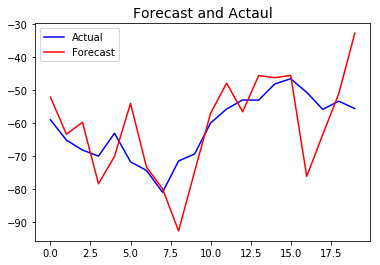

In [15]:
plt.title('Forecast and Actaul', fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), 'b', markersize=10, label='Actual')
plt.plot(pd.Series(np.ravel(y_pred)), 'r', markersize=10, label='Forecast')
plt.legend()
plt.show()

In [16]:
raw = pd.read_csv('USDRUB_180530_180531.csv', sep=';', names=['date', 'time', 'open', 'high', 'low', 'close', 'V'], header=0)
raw.index = raw.apply(lambda row: datetime.strptime(str(row['date']) + ' ' + str(row['time']), '%d/%m/%y %H:%M:%S'), axis=1)
#data.drop(data[data.V < 10000].index, inplace=True)
raw.drop(['date', 'time'], axis=1, inplace=True)

In [17]:
ts_test = np.array(raw['close'])

In [18]:
X_test, Y_test = test_data(ts_test, f_horizon, num_periods)

In [19]:
with tf.Session() as sess:
    init.run()
    y_pred = sess.run(outputs, feed_dict = {X: X_test})

In [20]:
Y_test

array([[[-59.0655787 ],
        [-65.23879642],
        [-68.24206651],
        [-70.08051124],
        [-63.15349664],
        [-71.79176185],
        [-74.43003138],
        [-81.02798218],
        [-71.55264221],
        [-69.42778271],
        [-60.0668078 ],
        [-55.81065677],
        [-53.07955007],
        [-53.1488995 ],
        [-48.25735289],
        [-46.66696793],
        [-50.78209572],
        [-55.9258956 ],
        [-53.46087492],
        [-55.68817268]]])

In [21]:
x_data.shape

(180,)

In [22]:
ts.shape

(209,)